### Descrizione del progetto

* L'obiettivo di questo progetto è quello di progettare un sistema in grado di classificare immagini di dimensione **28x28 pixel**, 
ciascuna rappresentante una lettera statica dell'alfabeto ASL (American Sign Language). Si escludono le lettere Y e Z poiché richiedono movimento.

* Verranno confrontati e valutati diversi modelli di Machine Learning affrontati durante il corso, al fine di identificare quello con la migliore combinazione di accuratezza e capacità di generalizzazione.

* I modelli analizzati saranno:
  - **Naive Bayes**
  - **MLPClassifier**
  - **SVM**
  - **Decision Tree**

In [1]:
# Import delle librerie necessarie 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [2]:

# Dizionario per mappare i numeri (0-25) alle lettere dell'alfabeto ASL per una migliore interpretazione delle classificazioni.
lettereALS = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I','J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
keys = list(range(26))
Lettere_keys = dict(zip(keys, lettereALS))


**1. Visualizzazione dei Dataset**

In [3]:
def visualize_dataset(dataset, str):
    '''
    Visualizza i primi 5 campioni del dataset. 
    Ogni immagine viene mostrata in una griglia 28x28 in scala di grigi, 
    con la lettera corrispondente.
    
    Args:
        dataset (pd.DataFrame): dataset
    '''
    # Statistiche di base
    print(dataset.head())
    print("Statistiche del dataset:")
    print(f"Numero di campioni: {dataset.shape[0]}")
    print(f"Numero di features: {dataset.shape[1]}")

    fig, axes = plt.subplots(1,5,figsize=(10, 3))
    fig.suptitle(f"Anteprima del dataset di {str}")
    for i, ax in enumerate(axes):
        target = dataset.iloc[i].values[0]
        pixels = dataset.iloc[i].values[1:]
        ax.imshow(pixels.reshape(28,28), cmap='gray')
        ax.set_title(f"{target} = {Lettere_keys[target]}")

    plt.show()

**2. Caricamento dei Dataset**

In [4]:
def load_datasets(train_path,test_path ):
    '''
    Carica i dataset di training e di testing e restituisce le feature e i 
    target separatamente.

    ARGS (str): 
        train_path (str): path del dataset di train
        test_path (str): path del dataset di test

    RETURNS:  
        tuple: x_train, y_train, x_test, y_test
    '''

    Train_data = pd.read_csv(train_path)
    Test_data = pd.read_csv(test_path)

    print("VISUALIZZAZIONE DATASET DI TRAIN")
    visualize_dataset(Train_data, "train")
    print("VISUALIZZAZIONE DATASET DI TEST")
    visualize_dataset(Test_data, "test")
    
    x_test = Test_data.iloc[:,1:].values
    y_test = Test_data.iloc[:,0].values

    x_train = Train_data.iloc[:,1:].values
    y_train = Train_data.iloc[:,0].values

    return x_train, y_train, x_test, y_test

**3. Exploratory Data Analisys (EDA)**

In [5]:
def perform_eda(X,y, dataset_name):
    '''
    Esegue l'analisi esplorativa dei dati analizzando la distribuzione delle classi
    e i valori dei pixel nel dataset. 

    Args:
        X (np.array): features
        y (np.array): target
    '''

    # Distribuzione delle classi
    plt.figure(figsize=(12,4))
    plt.suptitle(f"Distribuzione delle classi - {dataset_name}")
    plt.subplot(121)
    sns.histplot(y.flatten(), bins=np.arange(-0.5, 26.5, 1), color='red', alpha=0.7, edgecolor='black' )
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.title("Distribuzione delle classi")
    plt.xlabel("Classe")
    plt.ylabel("Conteggio")
    plt.xticks(keys, Lettere_keys.values())

    # Distribuzione dei pixel
    plt.subplot(122)
    plt.hist(X.flatten(), bins=256, color='blue', alpha=0.7)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.title("Distribuzione dei Valori dei Pixel")
    plt.xlabel("Valore del Pixel")
    plt.ylabel("Frequenza")
    plt.tight_layout()

    plt.show()
    

**4. Preprocessing**

In [6]:
def preprocess_data(x_train, y_train, x_test, y_test):
    '''
    Preprocessing dei dati: I dati vengono normalizzati per ottimizzare le performance
    dei modelli di Machine Learning.

    Args:
        x_train (np.array): features di train
        y_train (np.array): target di train
        x_test (np.array): features di test
        y_test (np.array): target di test

    Returns:
        tuple: x_train, y_train, x_test, y_test
    '''

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    return x_train, y_train, x_test, y_test

**5. Modelli Utilizzati**

In [7]:
def train_and_evaluate_models(x_train, y_train, x_test, y_test):
    '''
    Esegui l'addestramento e l'evaluazione dei modelli

    Args:
        x_train (np.array): features di train
        y_train (np.array): target di train
        x_test (np.array): features di test
        y_test (np.array): target di test
    '''
    param_grid = {'max_depth':[10,20,30,None]}
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
    grid_search.fit(x_train, y_train)
    print(grid_search.best_params_, grid_search.best_score_)

    # Modelli usati durante l'addestramento
    models = {
        'Naive Bayes': GaussianNB(),
        'MLPClassifier': MLPClassifier(
            hidden_layer_sizes=(128, 64), 
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42,
            alpha=0.00001, verbose=True),
        'SVM': SVC(kernel='linear', probability=True, random_state=42),
        'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=42)
    }

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name}...")
        # Addestramento
        model.fit(x_train, y_train)
        
        # Predizioni
        y_pred = model.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy {name}: {accuracy:.2f}")

        results[name] = {
            'accuracy': accuracy
        }

        # Stampa report di classificazione
        print(f"\nClassification Report - {name}:\n")
        print(classification_report(y_test, y_pred))

        # Matrice di confusione
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Matrice di Confusione - {name}')
        plt.xlabel('Predetto')
        plt.ylabel('Vero')
        plt.show()
    
    # Confronto delle performance
    model_names = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in model_names]

    plt.figure(figsize=(8, 5))
    plt.bar(model_names, accuracies, color=['blue', 'green', 'orange', 'red'])
    plt.title('Confronto Accuratezza Modelli')
    plt.xlabel('Modelli')
    plt.ylabel('Accuratezza')
    plt.ylim(0, 1)
    plt.show()

    return results


VISUALIZZAZIONE DATASET DI TRAIN
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784

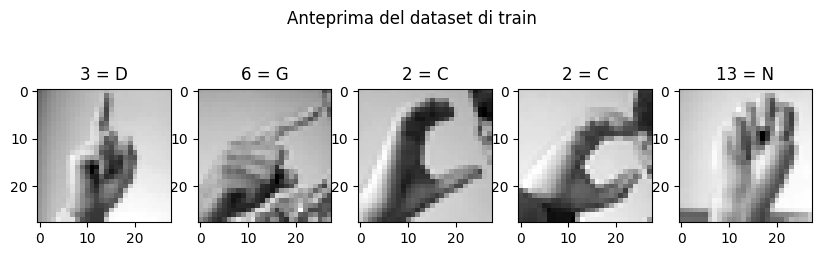

VISUALIZZAZIONE DATASET DI TEST
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     206     207     209     210     209   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   
3     210  ...       154       248       247       248       253       236   
4     203  ...        26        40        64        48        29        46   

   pixel781  pixel782  pixel783  pixel784 

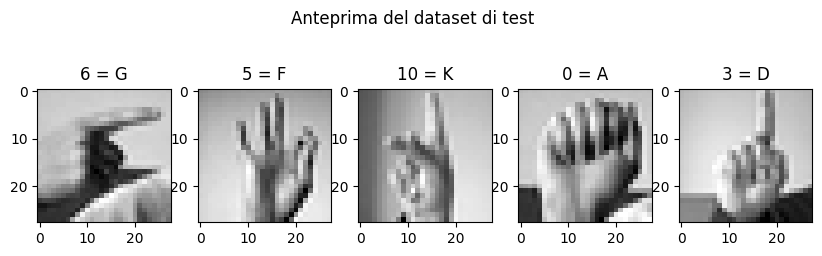

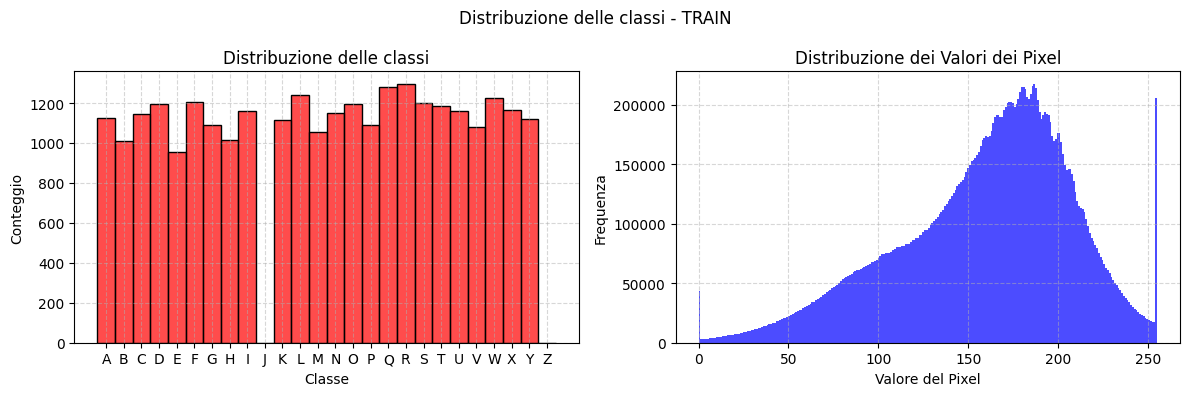

(27455, 784) (27455,) (7172, 784) (7172,)


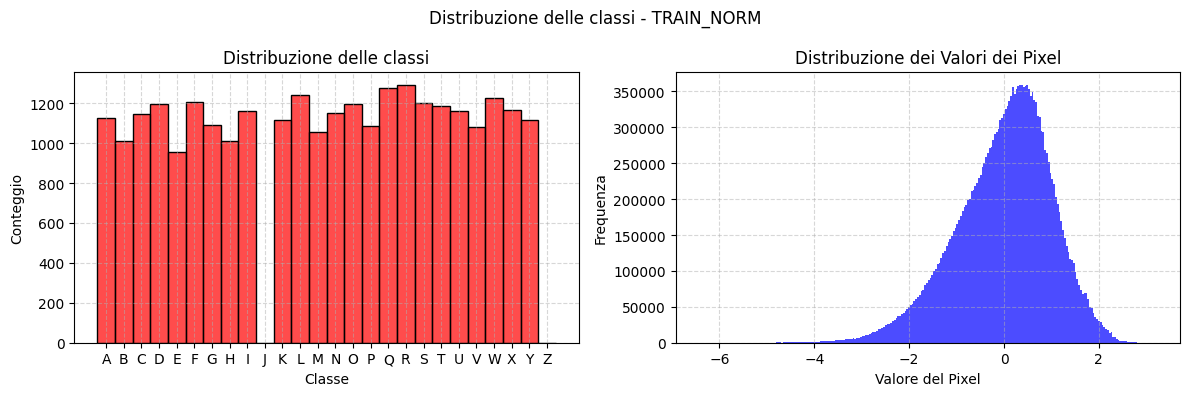

{'max_depth': 30} 0.88147878346385

Training Naive Bayes...
Accuracy Naive Bayes: 0.39

Classification Report - Naive Bayes:

              precision    recall  f1-score   support

           0       0.71      0.48      0.57       331
           1       0.96      0.40      0.56       432
           2       0.72      0.50      0.59       310
           3       0.60      0.40      0.48       245
           4       0.53      0.56      0.55       498
           5       0.39      0.26      0.31       247
           6       0.54      0.56      0.55       348
           7       0.85      0.39      0.53       436
           8       0.22      0.45      0.30       288
          10       0.27      0.41      0.33       331
          11       0.41      0.45      0.43       209
          12       0.37      0.19      0.25       394
          13       0.38      0.31      0.34       291
          14       0.37      0.49      0.42       246
          15       0.43      0.81      0.56       347
         

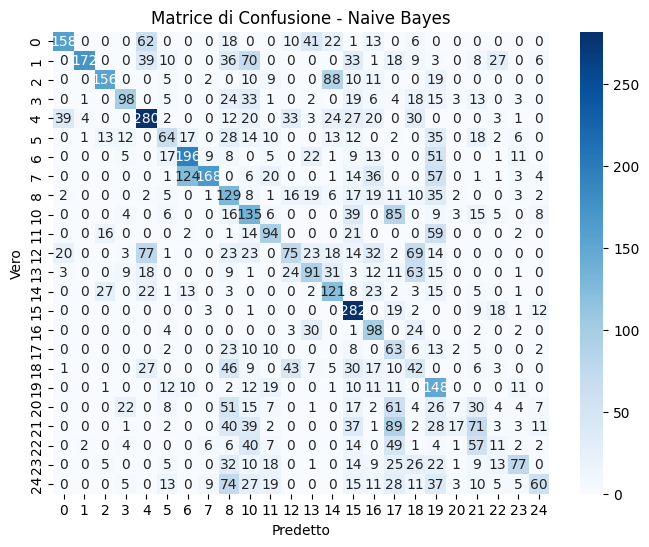


Training MLPClassifier...
Iteration 1, loss = 1.00940679
Iteration 2, loss = 0.06853575
Iteration 3, loss = 0.01605227
Iteration 4, loss = 0.00737605
Iteration 5, loss = 0.00429101
Iteration 6, loss = 0.00283084
Iteration 7, loss = 0.00200338
Iteration 8, loss = 0.00149584
Iteration 9, loss = 0.00115138
Iteration 10, loss = 0.00091146
Iteration 11, loss = 0.00074335
Iteration 12, loss = 0.00061325
Iteration 13, loss = 0.00051362
Iteration 14, loss = 0.00043585
Iteration 15, loss = 0.00037538
Iteration 16, loss = 0.00032441
Iteration 17, loss = 0.00028258
Iteration 18, loss = 0.00024848
Iteration 19, loss = 0.00021894
Iteration 20, loss = 0.00019470
Iteration 21, loss = 0.00017375
Iteration 22, loss = 0.00015606
Iteration 23, loss = 0.00014069
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Accuracy MLPClassifier: 0.80

Classification Report - MLPClassifier:

              precision    recall  f1-score   support

           0       0.88      1.

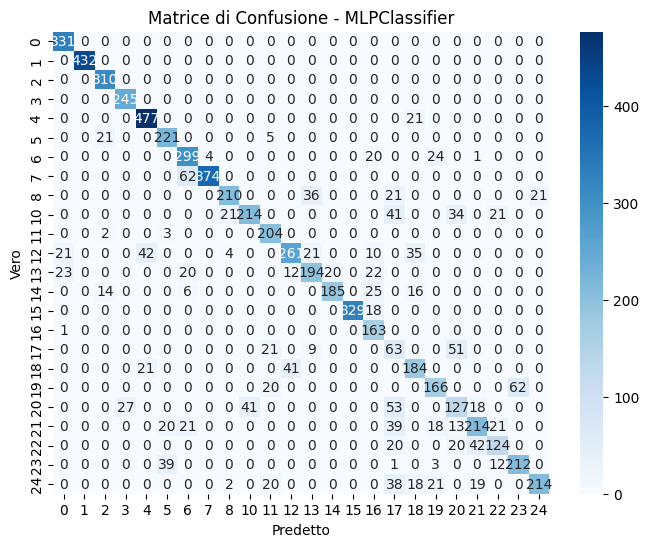


Training SVM...


In [ ]:
x_train, y_train, x_test, y_test = load_datasets("sign_mnist_train.csv", "sign_mnist_test.csv")

perform_eda(x_train, y_train, "TRAIN")

x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

perform_eda(x_train, y_train, "TRAIN_NORM")

results = train_and_evaluate_models(x_train, y_train, x_test, y_test)
print(results)
